In [27]:
!pip install pandas
!pip install pyarrow

!pip install Pillow
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install tqdm
!pip install ipdb
!pip install sentencepiece


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
import os


# os.chdir("/root/workspace/mlx44")
print(os.getcwd())
# root_path = Path(os.getcwd()).resolve().parents[0]
# print(root_path)
# os.chdir("/root/workspace/mlx44/src")
# os.mkdir(root_path / "workspace/mlx44")
root = Path("/Users/sid/workspace/mlx-week5")
train_data_path = root / "train"
train_data_path

/Users/sid/workspace/mlx-week5/sid/notebooks


PosixPath('/Users/sid/workspace/mlx-week5/train')

In [3]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import io
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import numpy as np
import itertools as its
from tqdm import tqdm
import ipdb
from collections import namedtuple
from importlib import reload

In [4]:
# How to check is mps is available on my M1 MAC?
torch.backends.mps.is_available()
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    #     else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

device(type='cpu')

# Load the data from a single parquet file

In [5]:
# read a parquet file into a pandas dataframe
import pandas as pd
import pyarrow.parquet as pq

first_file = pd.read_parquet(train_data_path / "0000.parquet", engine="pyarrow")

In [7]:
all_sentences = first_file["text"].values
all_sentences = all_sentences.tolist()
all_sentences[0:5]

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

In [8]:
len(all_sentences)

529930

# Use sentence piece to tokenize the sentences

In [9]:
# Lets tokenize using sentence piece
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
import io

VOCAB_SIZE = 10000
SOS = "<SOS>"
EOS = "<EOS>"


# for article in articles[0:100]:
def get_data():
    for i in range(100):
        file = pd.read_parquet(
            train_data_path / f"{str(i).zfill(4)}.parquet", engine="pyarrow"
        )
        for sentence in file["text"].values:
            yield sentence


def get_model(train=False):
    model = io.BytesIO()
    model_filename = root / "models/tiny_stories_tokenizer.model"
    if train:
        SentencePieceTrainer.train(
            sentence_iterator=iter(all_sentences),
            model_writer=model,
            vocab_size=VOCAB_SIZE,
            user_defined_symbols=[SOS, EOS],
            # max_sentence_length=4196,
            # model_type="BPE",
        )
        sp_processor = SentencePieceProcessor(model_proto=model.getvalue())
    else:
        sp_processor = SentencePieceProcessor(model_file=str(model_filename))
    return sp_processor, model


def save_model(model):
    model_filename = root / "models/tiny_stories_tokenizer.model"
    with open(model_filename, "wb") as f:
        f.write(model.getvalue())

In [308]:
sp_processor, model = get_model(train=False)

In [36]:
# EXECUTE ONCE WHEN YOU HAVE IT MADE
# save_model(model)

In [12]:
print(all_sentences[100])
print(".")
print(
    " ".join(
        list(
            set(
                [
                    w
                    for lst in sp_processor.encode_as_pieces(all_sentences[100:102])
                    for w in lst
                ]
            )
        )
    )
)
print("..")
print(sp_processor.encode_as_pieces(all_sentences[100:102]))
print("...")
print(sp_processor.encode_as_ids(all_sentences[100:102]))

There was a little girl with dark hair. Her name was Joy. She lived in a big house with her parents. One day, Joy was playing outside in her garden. Suddenly, she felt something on her leg - something pinching her. It was a big, black bug! 

Joy screamed and tried to get away, but the bug kept following her. She tried to run and hide, but it was too quick. 

Joy's parents heard her cries and came running. They used a stick to help her get rid of the bug. After the bug was gone, they hugged Joy and told her everything would be alright. 

When the bug was gone, Joy felt relieved and happy. She went back to playing in the garden, making sure she didn't step on any more bugs.
.
▁part . TMs ▁happy ▁kind ▁There ! R ▁gentle ▁sad ▁treat ." ▁of ▁everything s ▁got ▁He When ▁girl ▁things ▁smiled ▁day ▁rid ▁decided ▁After ▁relieved ▁said ▁didn ▁named ▁told ▁because ▁like ▁taught ▁lesson ▁respect ▁fix ▁nice , ▁little ▁came ▁When ▁there ▁dark ▁too ▁shiny ▁broken ▁As ▁stick ▁searching ▁cries ▁quietly

In [229]:
sp_processor.encode_as_pieces(
    "<SOS> hen the bug was gone, Joy felt relieved and happy. She went <EOS>"
)

# sp_processor.encode_as_ids("<SOS>en the bug was gone, Joy felt relieved and happy. She went <EOS>")
for sentence in all_sentences[100:110]:
    sentence = f"<SOS>{sentence}<EOS>"
    print(sp_processor.encode_as_pieces(sentence))
# sp_processor.encode_as_pieces("<SOS>hen the bug was gone, Joy felt relieved and happy. She went<EOS>")

['▁', '<SOS>', 'There', '▁was', '▁a', '▁little', '▁girl', '▁with', '▁dark', '▁hair', '.', '▁Her', '▁name', '▁was', '▁Joy', '.', '▁She', '▁lived', '▁in', '▁a', '▁big', '▁house', '▁with', '▁her', '▁parents', '.', '▁One', '▁day', ',', '▁Joy', '▁was', '▁playing', '▁outside', '▁in', '▁her', '▁garden', '.', '▁Suddenly', ',', '▁she', '▁felt', '▁something', '▁on', '▁her', '▁leg', '▁-', '▁something', '▁pinching', '▁her', '.', '▁It', '▁was', '▁a', '▁big', ',', '▁black', '▁bug', '!', '▁Joy', '▁screamed', '▁and', '▁tried', '▁to', '▁get', '▁away', ',', '▁but', '▁the', '▁bug', '▁kept', '▁following', '▁her', '.', '▁She', '▁tried', '▁to', '▁run', '▁and', '▁hide', ',', '▁but', '▁it', '▁was', '▁too', '▁quick', '.', '▁Joy', "'", 's', '▁parents', '▁heard', '▁her', '▁cries', '▁and', '▁came', '▁running', '.', '▁They', '▁used', '▁a', '▁stick', '▁to', '▁help', '▁her', '▁get', '▁rid', '▁of', '▁the', '▁bug', '.', '▁After', '▁the', '▁bug', '▁was', '▁gone', ',', '▁they', '▁hugged', '▁Joy', '▁and', '▁told', '▁her'

In [13]:
sentence_tokens = sp_processor.encode_as_ids(all_sentences[0:10000])

# Data generation utilities

In [180]:
# Lets create a dataset
T = 16  # Window size
V = VOCAB_SIZE
B = 64
SOS = "<SOS>"
EOS = "<EOS>"


# This is a bit slow because it generates S*(N - T) samples of length T each, where S is the number of sentences and N is the number of tokens in the sentence
# TODO: stupidly parallelize and load it into a numpy array and save it to a file, then memory map that file and load it into a torch tensor.
def data_generator(tokens):
    xy = []  # x: T word window, y is T+1th word

    for sentence_tokens in tokens:
        for i in range(0, len(sentence_tokens) - T):
            yield sentence_tokens[i : i + T], sentence_tokens[i + 1 : (i + T + 1)]


for x, y in data_generator(sp_processor.encode_as_ids(all_sentences[100:101])):
    print(x, y)

[526, 11, 10, 40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254] [11, 10, 40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22]
[11, 10, 40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22] [10, 40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10]
[10, 40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10] [40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48]
[40, 61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48] [61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179]
[61, 24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179] [24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179, 24]
[24, 507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179, 24] [507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179, 24, 15]
[507, 587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179, 24, 15] [587, 5, 174, 450, 11, 2821, 5, 14, 254, 22, 10, 48, 179, 24, 15, 464]
[587, 5, 174

In [230]:
[f"<SOS>{sentence}<EOS>" for sentence in all_sentences[0:20]]

['<SOS>One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<EOS>',
 '<SOS>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many

In [231]:
all_data = list(
    data_generator(
        sp_processor.encode_as_ids(
            [f"<SOS>{sentence}<EOS>" for sentence in all_sentences[0:2000]]
        )
    )
)

In [232]:
all_data[0:5]  # This is what the data looks like.

[([51, 3, 3309, 28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199],
  [3, 3309, 28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5]),
 ([3, 3309, 28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5],
  [3309, 28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14]),
 ([3309, 28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14],
  [28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14, 169]),
 ([28, 8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14, 169],
  [8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14, 169, 12]),
 ([8, 10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14, 169, 12],
  [10, 40, 61, 83, 26, 124, 10, 1969, 22, 15, 199, 5, 14, 169, 12, 11])]

In [189]:
input.view(input.size(0), -1, input.size(1)).shape

torch.Size([1, 100, 20])

In [224]:
# With Learnable Parameters
m = nn.BatchNorm1d(4, track_running_stats=True)
# Without Learnable Parameters
# m = nn.BatchNorm1d(3, affine=False)
input = torch.randn(1, 4, 4)
input_view = input.permute(0, 2, 1)
print(input.shape)
print(input_view.shape)
print(input)
print(input_view)
output = m(input_view)
output.shape, output.permute(0, 2, 1)

torch.Size([1, 4, 4])
torch.Size([1, 4, 4])
tensor([[[ 0.3896, -1.1158, -0.0776,  0.2005],
         [-0.5921, -0.7588,  1.7235, -0.2645],
         [ 0.4052, -1.4948, -1.2203, -0.2848],
         [-0.1106, -0.8791,  0.5177,  0.1964]]])
tensor([[[ 0.3896, -0.5921,  0.4052, -0.1106],
         [-1.1158, -0.7588, -1.4948, -0.8791],
         [-0.0776,  1.7235, -1.2203,  0.5177],
         [ 0.2005, -0.2645, -0.2848,  0.1964]]])


(torch.Size([1, 4, 4]),
 tensor([[[ 0.8913, -0.1910, -0.2951,  1.0082],
          [-1.4955,  1.0798,  1.4008, -0.9566],
          [ 0.9291, -1.5403, -1.3711, -1.0423],
          [-0.3249,  0.6515,  0.2655,  0.9907]]], grad_fn=<PermuteBackward0>))

In [201]:
print(m.running_mean, m.running_var, m.weight, m.bias)
for i in m.parameters():
    print(i)

tensor([-0.0199, -0.1250,  0.0559, -0.0535]) tensor([0.9924, 0.9283, 0.9085, 0.9216]) Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True) Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)


# The model

In [278]:
from itertools import chain

N_EMBED = 512
N_HIDDEN = 512
V = VOCAB_SIZE


# C = nn.Embedding(V, N_EMBED)
# The Query, Key and Value matrics for self attention
class TinyStoriesTransformer(nn.Module):
    def __init__(self):
        super(TinyStoriesTransformer, self).__init__()
        self.C = nn.Embedding(V, N_EMBED)
        self.bn = nn.BatchNorm1d(N_EMBED, track_running_stats=True)
        # TODO(Sid): Add positional encoding and 3 separate layers for a forward projection *before* passing to Wq, Wk and Wv
        self.Wq = nn.Linear(N_EMBED, N_HIDDEN)
        self.Wk = nn.Linear(N_EMBED, N_HIDDEN)
        self.Wv = nn.Linear(N_EMBED, N_HIDDEN)

        # Layer norm layer
        self.ln_att = nn.LayerNorm(N_HIDDEN)
        # Full MLP
        self.ff = nn.Sequential(
            nn.Linear(N_HIDDEN, N_HIDDEN // 2),
            nn.ReLU(),
            nn.Linear(N_HIDDEN // 2, N_HIDDEN),
        )
        self.bn_after_ff = nn.BatchNorm1d(N_HIDDEN, track_running_stats=True)
        self.ln_ff = nn.LayerNorm(N_HIDDEN)

        # Softmax layer
        self.final_projection = nn.Linear(N_HIDDEN, V)

    def forward(self, x):
        x_embed = self.C(x)  # T * N_EMBED
        x_embed_permuted = x_embed.permute(0, 2, 1)  # N_EMBED * T
        x_embed_normed = self.bn(x_embed_permuted)
        x_embed_normed = x_embed_normed.permute(0, 2, 1)  # T * N_EMBED
        # Sublayer 1
        q = self.Wq(x_embed_normed)  # T * N_HIDDEN
        k = self.Wk(x_embed_normed)  # T * N_HIDDEN
        v = self.Wv(x_embed_normed)  # T * N_HIDDEN

        a = torch.bmm(q, k.transpose(-2, -1)) / (N_HIDDEN**0.5)
        self.effective_T = a.shape[1]
        mask = torch.tril(torch.ones(self.effective_T, self.effective_T))
        mask = mask.masked_fill(
            mask[: self.effective_T, : self.effective_T] == 0, float("-inf")
        )
        self.a = a
        a = a + mask
        self.a_softmax = torch.functional.F.softmax(a, dim=-1)

        weighted_attention = self.a_softmax @ v  # T * N_HIDDEN
        attention_output = self.ln_att(
            weighted_attention + x_embed_normed
        )  # T * N_HIDDEN, Residual connection
        # layer_norm_output = self.ln(attention_output)

        # Sub layer 2
        ff_output = self.ff(attention_output)  # T * N_HIDDEN
        ff_output_permuted = ff_output.permute(0, 2, 1)
        ff_output_normed = self.bn_after_ff(ff_output_permuted)
        ff_output_normed = ff_output_normed.permute(0, 2, 1)
        layer_norm_output_final = self.ln_ff(
            attention_output + ff_output_normed
        )  # T * N_HIDDEN, Residual connection
        return self.final_projection(layer_norm_output_final)  # B * T * V

## Initialize the model

In [282]:
tiny_story_model = TinyStoriesTransformer()
tiny_story_model.to(device)

TinyStoriesTransformer(
  (C): Embedding(10000, 512)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Wq): Linear(in_features=512, out_features=512, bias=True)
  (Wk): Linear(in_features=512, out_features=512, bias=True)
  (Wv): Linear(in_features=512, out_features=512, bias=True)
  (ln_att): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ff): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
  )
  (bn_after_ff): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln_ff): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (final_projection): Linear(in_features=512, out_features=10000, bias=True)
)

In [283]:
LEARNING_RATE = 0.001
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    tiny_story_model.parameters(),
    lr=LEARNING_RATE,
)
# for parameter_values in parameters:
#     for parameter in parameter_values:
#         print(".", end="")
#         parameter.requires_grad = True

# Over fit a batch 

In [236]:
X = torch.tensor([i[0] for i in all_data])
Y = torch.tensor([i[1] for i in all_data])

In [237]:
X.shape, Y.shape

(torch.Size([372012, 16]), torch.Size([372012, 16]))

In [268]:
x_sample, y_sample = X[0:200, :], Y[0:200, :]

In [239]:
print(x_sample[0:10, :])
print(y_sample[0:10, :])

tensor([[  53,   28,    8,   10,   40,   61,   83,   26,  124,   10, 1969,   22,
           15,  199,    5,   14],
        [  28,    8,   10,   40,   61,   83,   26,  124,   10, 1969,   22,   15,
          199,    5,   14,  169],
        [   8,   10,   40,   61,   83,   26,  124,   10, 1969,   22,   15,  199,
            5,   14,  169,   12],
        [  10,   40,   61,   83,   26,  124,   10, 1969,   22,   15,  199,    5,
           14,  169,   12,   11],
        [  40,   61,   83,   26,  124,   10, 1969,   22,   15,  199,    5,   14,
          169,   12,   11, 1445],
        [  61,   83,   26,  124,   10, 1969,   22,   15,  199,    5,   14,  169,
           12,   11, 1445,    9],
        [  83,   26,  124,   10, 1969,   22,   15,  199,    5,   14,  169,   12,
           11, 1445,    9,   57],
        [  26,  124,   10, 1969,   22,   15,  199,    5,   14,  169,   12,   11,
         1445,    9,   57,   24],
        [ 124,   10, 1969,   22,   15,  199,    5,   14,  169,   12,   11, 1445,

In [275]:
x_sample.shape

torch.Size([200, 16])

In [284]:
def save_model(model, model_path, epoch, optimizer, loss):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        model_path,
    )


def load_model(model, model_path, optimizer):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

In [215]:
train_loss_values = []

In [327]:
n_epochs = 200
epochs_iter = iter(range(n_epochs))
tiny_story_model.train()
with tqdm(total=n_epochs, desc="Epochs", leave=False) as progress_bar:
    for epoch in epochs_iter:
        optimizer.zero_grad()
        z = tiny_story_model(x_sample)
        act = torch.softmax(z, dim=-1)  # B* T * V, where V is the
        # print(act.shape, y_sample.shape)

        act = act.view(-1, V)
        y_sample_view = y_sample.view(-1)

        loss = ce_loss(act, y_sample_view)

        train_loss_values.append(loss.item())
        if epoch % 10 == 0:
            # print(".", end="")
            progress_bar.set_description(
                f"Epoch [{epoch+1}/{n_epochs}], Loss: {np.round(loss.item(), decimals=4)}, Last 5 losses: {', '.join([str(np.round(i, decimals=4)) for i in train_loss_values[-5:]])}"
            )
        if epoch + 1 % 100 == 0:
            save_model(
                tiny_story_model,
                f"model_overfitted_epoch_{(epoch+1)}_batch_{(epoch+1)}.pth",
                epoch,
                optimizer,
                loss,
            )
        # print(loss.item())
        loss.backward()
        optimizer.step()

    # Cross entropy between the output of the FF layer_norm_output_final and the target y
    # print(act.shape)

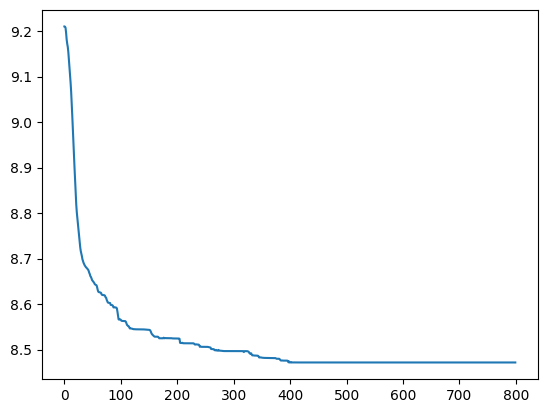

In [333]:
ax = plt.plot(train_loss_values[600:])

In [ ]:
)

# Inference 

In [345]:
dummy_model = TinyStoriesTransformer()
dummy_model.to(device)

TinyStoriesTransformer(
  (C): Embedding(10000, 512)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Wq): Linear(in_features=512, out_features=512, bias=True)
  (Wk): Linear(in_features=512, out_features=512, bias=True)
  (Wv): Linear(in_features=512, out_features=512, bias=True)
  (ln_att): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ff): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
  )
  (bn_after_ff): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln_ff): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (final_projection): Linear(in_features=512, out_features=10000, bias=True)
)

In [351]:
# grab a random token and make the network generate things
# def generate_text(model, sp_processor, test_sentence):
test_sentence = "There was a "
tiny_story_model.eval()
# token = torch.randint(0, V, (1, 1)).to(device)
tokens = sp_processor.encode_as_ids(f"<SOS>{test_sentence}")
print(tokens)
generated_text = []

tokens = torch.tensor([tokens]).to(device)
prev_tokens = tokens
print(tokens.shape)
for i in range(50):
    with torch.no_grad():
        z = tiny_story_model(prev_tokens)
        act = torch.softmax(z, dim=-1)
        act = act.view(-1, V)  # len(generated_tokens) +i * V
        token = torch.argmax(act, dim=-1)
        # print(token.shape)
        token = token[-1]
        # print(token)
        # print('.')
        generated_text.append(int(token))
        prev_tokens = torch.cat((prev_tokens, torch.tensor([[token]])), dim=1)
print(test_sentence + " [" + sp_processor.decode_ids(generated_text) + " ]")

[51, 3, 1900, 11, 10]
torch.Size([1, 5])
There was a  [little girl named Beep loved to go fast and said, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, "Mom, ]


array([1.0000000e+00, 1.2472578e-01, 8.7527424e-01, ..., 3.5056533e-07,
       1.4254650e-03, 6.5302983e-02], dtype=float32)

1549 3249
[1.14454900e-28 3.63722359e-26 1.72720156e-05 1.42857149e-01
 6.00345945e-01]


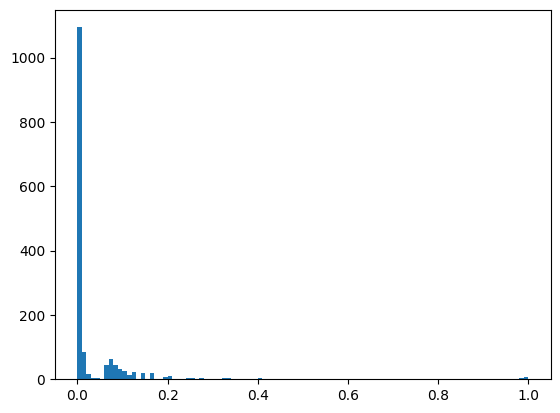

In [343]:
ax = plt.subplot()
vals = tiny_story_model.a_softmax.view(-1).detach().numpy()
print(np.count_nonzero(vals), len(vals))
non_zeros = vals[np.where(vals != 0)]
print(np.quantile(non_zeros, [0.01, 0.05, 0.5, 0.95, 0.99]))
_ = ax.hist(non_zeros, bins=100)

In [132]:
# Example of target with class indices
random_loss = nn.CrossEntropyLoss()
input = torch.tensor(
    [
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
        [
            [0.9, 5.8, 0.2, -0.65, 0.3],
            [0.9, -1.8, 0.2, 0.65, 7.3],
            [10.9, -1.8, 0.2, -0.65, 0.3],
        ],
    ],
    requires_grad=True,
)
target = torch.tensor([[1, 4, 0], [2, 1, 1]], dtype=torch.long)
print(input.shape, target.shape)
print(input, target)
input_view = input.view(-1, 5)
target_view = target.view(-1)
print(input_view.shape, target_view.shape)
print(input_view, target_view)
print(".")
output = random_loss(input_view, target_view)
print(output)
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

torch.Size([2, 3, 5]) torch.Size([2, 3])
tensor([[[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],

        [[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
         [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
         [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]]], requires_grad=True) tensor([[1, 4, 0],
        [2, 1, 1]])
torch.Size([6, 5]) torch.Size([6])
tensor([[ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000,  5.8000,  0.2000, -0.6500,  0.3000],
        [ 0.9000, -1.8000,  0.2000,  0.6500,  7.3000],
        [10.9000, -1.8000,  0.2000, -0.6500,  0.3000]],
       grad_fn=<ViewBackward0>) tensor([1, 4, 0, 2, 1, 1])
.
tensor(4.5735, grad_fn=<NllLossBackward0>)
